In [1]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt

movies = pd.read_csv('ml-latest-small/movies.csv')

ratings = pd.read_csv('ml-latest-small/ratings.csv')

tags = pd.read_csv('ml-latest-small/tags.csv')

In [2]:
import warnings
warnings.filterwarnings('ignore')

Raw Data inspection

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = ratings.drop('timestamp' , axis=1)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [5]:
tags = tags.drop('timestamp', axis=1)
tags.head()

,userId,movieId,tag
0,2,60756,funny
1,2,60756,Highly quotable
2,2,60756,will ferrell
3,2,89774,Boxing story
4,2,89774,MMA


In [6]:
print('The dataset contains: ', len(ratings), ' ratings of ', len(movies), ' movies by ', len(ratings['userId'].unique()), ' users.')

The dataset contains:  100836  ratings of  9742  movies by  610  users.


Dataset manipulation and creation of Datapoints for clustering


First I'll find the 3 most popular genres and tags among users to perform clustering and to visualize the results in a clearer way.
Then I will try using all different genres/tags and finally I will make use of Dimensionality reduction through PCA.
Eventually a comparision will be made for the three methods using different evaluation metrics in order to find the better clustering strategy for building a Movie recommender system.

In [7]:
# find 3 most rated genres
movie_genres = movies['genres'].apply(lambda x: x.split('|'))
genres = movie_genres.apply(pd.Series).stack().value_counts()
genres.head(3)

Drama       4361
Comedy      3756
Thriller    1894
Name: count, dtype: int64

In [8]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    genre_ratings = pd.concat([genre_ratings,pd.DataFrame(set(ratings['userId']))], axis=1)
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings
# Calculate the average rating of romance and scifi movies
#genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi', 'Adventure'], ['userId', 'Romance', 'Sci-Fi', 'Adventure'])
genre_ratings = get_genre_ratings(ratings, movies, ['Drama', 'Comedy', 'Thriller'], ['userId', 'Drama', 'Comedy', 'Thriller'])

genre_ratings.head()


,userId,Drama,Comedy,Thriller
0,1.0,NaN,NaN,NaN
1,2.0,4.53,4.28,4.15
2,3.0,3.88,4.00,3.70
3,4.0,0.75,1.00,4.14
4,5.0,3.48,3.51,3.55


In [9]:
# Remove missing values
genre_ratings = genre_ratings.dropna()

In [10]:
# find the most rated tags
tag_counts = tags['tag'].value_counts()
tag_counts.head(3)

tag
In Netflix queue     131
atmospheric           36
thought-provoking     24
Name: count, dtype: int64

In [11]:
def get_tag_ratings(ratings, tag_data, tags, column_names):
    #tag_data = tag_data.dropna()
    tag_ratings = pd.DataFrame()
    tag_ratings = pd.concat([tag_ratings,pd.DataFrame(set(ratings['userId']))], axis=1)
    for tag in tags:        
        tag_movies = tag_data[tag_data['tag'].str.contains(tag) ]
        avg_tag_votes_per_user = ratings[ratings['movieId'].isin(tag_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        tag_ratings = pd.concat([tag_ratings, avg_tag_votes_per_user], axis=1)
        
    tag_ratings.columns = column_names
    return tag_ratings

# Calculate the average rating of funny and fantasy movies
#tag_ratings = get_tag_ratings(ratings, tags, ['funny', 'fantasy', 'mafia'], ['userId', 'funny', 'fantasy', 'mafia'])
tag_ratings = get_tag_ratings(ratings, tags, ['In Netflix queue', 'atmospheric', 'thought-provoking'], ['userId', 'In Netflix queue', 'atmospheric', 'thought-provoking'])

tag_ratings.head()


,userId,In Netflix queue,atmospheric,thought-provoking
0,1.0,NaN,NaN,NaN
1,2.0,4.0,3.67,4.50
2,3.0,NaN,4.00,3.67
3,4.0,NaN,NaN,0.50
4,5.0,4.5,2.00,2.67


In [12]:
# Remove missing values
tag_ratings = tag_ratings.dropna()

Biasing dataset to obtain a more delimited subset of people

In [13]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    return genre_ratings[((genre_ratings['Drama'] < score_limit_1 - 0.2) & (genre_ratings['Comedy'] > score_limit_2)) | ((genre_ratings['Comedy'] < score_limit_1) & (genre_ratings['Drama'] > score_limit_2))]
# Bias the dataset
genre_ratings_biased = bias_genre_rating_dataset(genre_ratings, 3.5, 2.3)
genre_ratings_biased = genre_ratings_biased.reset_index(drop=True)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(genre_ratings_biased))

Number of records:  262


In [14]:
def bias_tag_rating_dataset(tag_ratings, score_limit_1, score_limit_2):
    return tag_ratings[((tag_ratings['atmospheric'] < score_limit_1 - 0.2) & (tag_ratings['In Netflix queue'] > score_limit_2)) | ((tag_ratings['In Netflix queue'] < score_limit_1) & (tag_ratings['atmospheric'] > score_limit_2))]
# Bias the dataset
tag_ratings_biased = bias_tag_rating_dataset(tag_ratings, 3.5, 2.3)
tag_ratings_biased = tag_ratings_biased.reset_index(drop=True)
# Printing the resulting number of records & the head of the dataset
print( "Number of records: ", len(tag_ratings_biased))

Number of records:  53


Visualization of Data

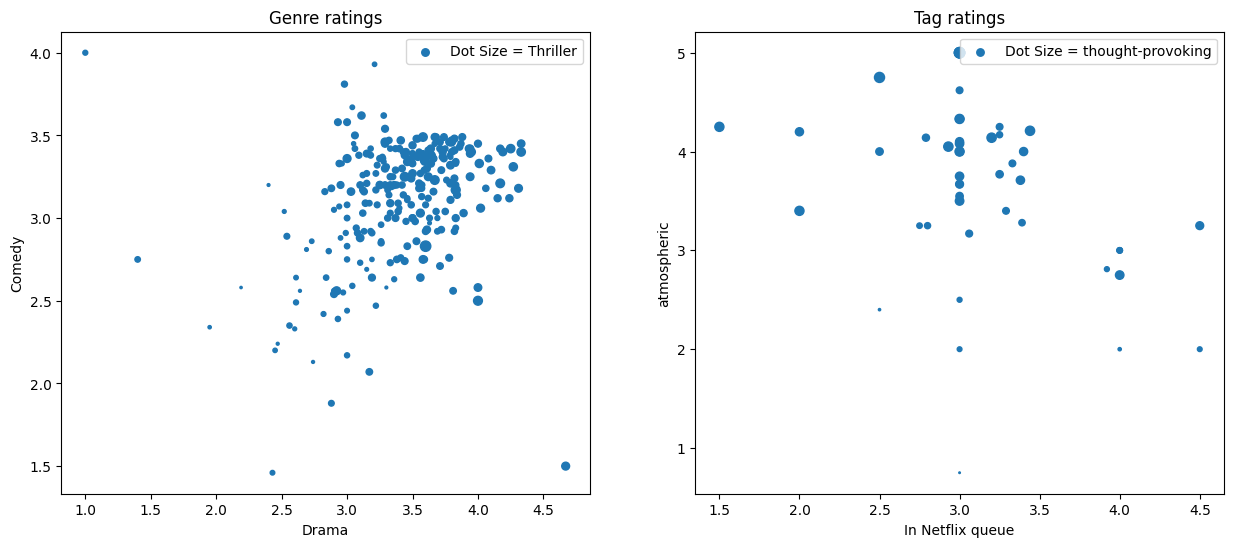

In [15]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121)
ax.scatter(genre_ratings_biased['Drama'],genre_ratings_biased['Comedy'], s=genre_ratings_biased['Thriller']**2.5, label='Dot Size = Thriller')
ax.set_xlabel('Drama')
ax.set_ylabel('Comedy')
ax.set_title('Genre ratings')
ax.legend()

ax = fig.add_subplot(122)
ax.scatter(tag_ratings_biased['In Netflix queue'], tag_ratings_biased['atmospheric'], s=tag_ratings_biased['thought-provoking']**2.5, label = 'Dot Size = thought-provoking')
ax.set_xlabel('In Netflix queue')
ax.set_ylabel('atmospheric')
ax.set_title('Tag ratings')
ax.legend()


Training and test set separiation

In [16]:
#divide the data into training and test set by 80% and 20% respectively

movies_train = genre_ratings_biased.sample(frac=0.8, random_state=0)
movies_test = genre_ratings_biased.drop(movies_train.index)

tags_train = tag_ratings_biased.sample(frac=0.8, random_state=0)
tags_test = tag_ratings_biased.drop(tags_train.index)

Clustering

In [17]:
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans, AffinityPropagation , MeanShift, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


clustering_methods = [KMeans, Birch, MiniBatchKMeans, AffinityPropagation , 
                      MeanShift, SpectralClustering, AgglomerativeClustering] 

In [18]:
#create a function to plot the clusters in 3d and 2d with input the vector of predicted clusters for genres and tags respectively

def plot_clusters_3d(X, Y, predictions, genre_k, tag_k):
    
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X['Drama'],X['Comedy'],X['Thriller'], c=predictions[0].labels_, cmap='tab10')
    ax.set_xlabel('Sci-Fi')
    ax.set_ylabel('Romance')
    ax.set_zlabel('Adventure')
    ax.set_title('Clusters by favourite genres with K = ' + str(genre_k))

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(Y['In Netflix queue'], Y['atmospheric'], Y['thought-provoking'], c=predictions[1].labels_, cmap='tab10')
    ax.set_xlabel('Funny')
    ax.set_ylabel('Fantasy')
    ax.set_zlabel('Mafia')
    ax.set_title('Clusters by favourite tags with K = ' + str(tag_k))

    plt.show()
'''
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(121)
    ax.scatter(X['Drama'],X['Comedy'],c=predictions[0].labels_, cmap='tab10', s=X['Thriller']**3)
    ax.set_xlabel('Sci-Fi')
    ax.set_ylabel('Romance')
    ax.set_title('Genre clustering, K = ' + str(genre_k) + ' (size = Adventure)')

    ax = fig.add_subplot(122)
    ax.scatter(Y['In Netflix queue'], Y['atmospheric'], c=predictions[1].labels_, cmap='tab10', s=Y['thought-provoking']**3)
    ax.set_xlabel('Funny')
    ax.set_ylabel('Fantasy')
    ax.set_title('Tag clustering, K = ' + str(tag_k) + ' (size = Mafia)')

    plt.show()
    '''

"\n    fig = plt.figure(figsize=(15,6))\n    ax = fig.add_subplot(121)\n    ax.scatter(X['Drama'],X['Comedy'],c=predictions[0].labels_, cmap='tab10', s=X['Thriller']**3)\n    ax.set_xlabel('Sci-Fi')\n    ax.set_ylabel('Romance')\n    ax.set_title('Genre clustering, K = ' + str(genre_k) + ' (size = Adventure)')\n\n    ax = fig.add_subplot(122)\n    ax.scatter(Y['In Netflix queue'], Y['atmospheric'], c=predictions[1].labels_, cmap='tab10', s=Y['thought-provoking']**3)\n    ax.set_xlabel('Funny')\n    ax.set_ylabel('Fantasy')\n    ax.set_title('Tag clustering, K = ' + str(tag_k) + ' (size = Mafia)')\n\n    plt.show()\n    "

In [19]:
def Cluster_data(data, n_clusters, cluster_function):
    X = data.copy()
    X = X.drop('userId', axis=1)
    if(cluster_function in [MeanShift, AffinityPropagation, SpectralClustering]):
        cluster = cluster_function()
    else:
        cluster = cluster_function(n_clusters=n_clusters)
    predictions = cluster.fit_predict(X)
    return cluster

In [20]:
#function to plot silhouette score for different number of clusters and different clustering methods
def silhouette_score_plot(data, method, title):
    trials = 1

    mean_genre_score = []
    for trial in range(trials):
        genre_score = []
        for i in range(2, 20):
            X = data[0].copy()
            X = X.drop('userId', axis=1)
            model = method(n_clusters=i)
            labels = model.fit_predict(X)
            genre_score.append(silhouette_score(X, labels))
        mean_genre_score.append(genre_score)

    mean_genre_score = np.mean(mean_genre_score, axis=0)    

    best_genre_K = np.argmax(mean_genre_score) + 2
    if best_genre_K == 2:
        best_genre_K = 3

    mean_tag_score = []
    for trial in range(trials):
        tag_score = []    
        for i in range(2, 20):
            X = data[1].copy()
            X = X.drop('userId', axis=1)
            model = method(n_clusters=i)
            labels = model.fit_predict(X)
            #compute silhouette score for tags
            tag_score.append(silhouette_score(X, labels))
        mean_tag_score.append(tag_score)

    mean_tag_score = np.mean(mean_tag_score, axis=0)     

    best_tag_K = np.argmax(mean_tag_score) + 2
    if best_tag_K == 2:
        best_tag_K = 3

    #plot silhouette score
    _ , ax = plt.subplots(ncols=2, nrows=1, figsize=(15,3))

    ax[0].plot(range(2, 20), mean_genre_score)
    ax[0].set_title('Silhouette score for genres')
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('Silhouette score')
    ax[0].grid()
    ax[1].plot(range(2, 20), mean_tag_score)
    ax[1].set_title('Silhouette score for tags')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Silhouette score')
    ax[1].grid()
    plt.suptitle(title)
    plt.show()

    return best_genre_K, best_tag_K

For algorithms that requires to select the numebr of clusters, I plotted the silhouette score for some values of K to choose the best number of clusters, the higher the better.

KMeans Clustering algorithm                                                            

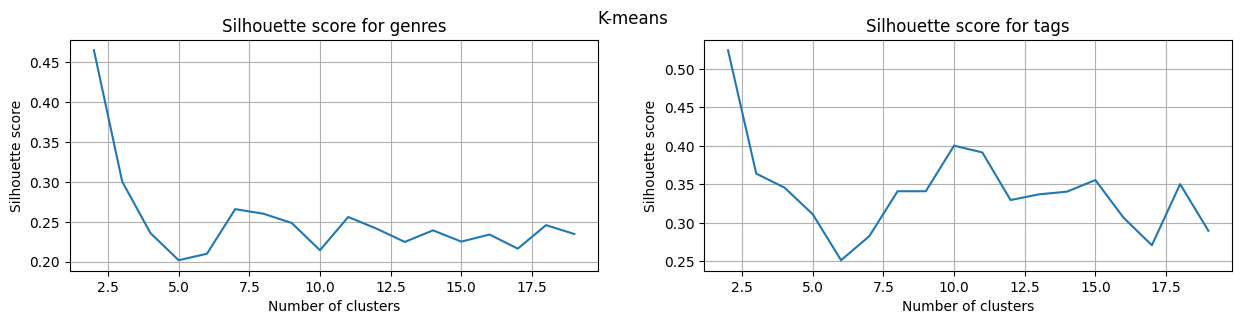

In [21]:
#optimization of K for KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], KMeans,'K-means')

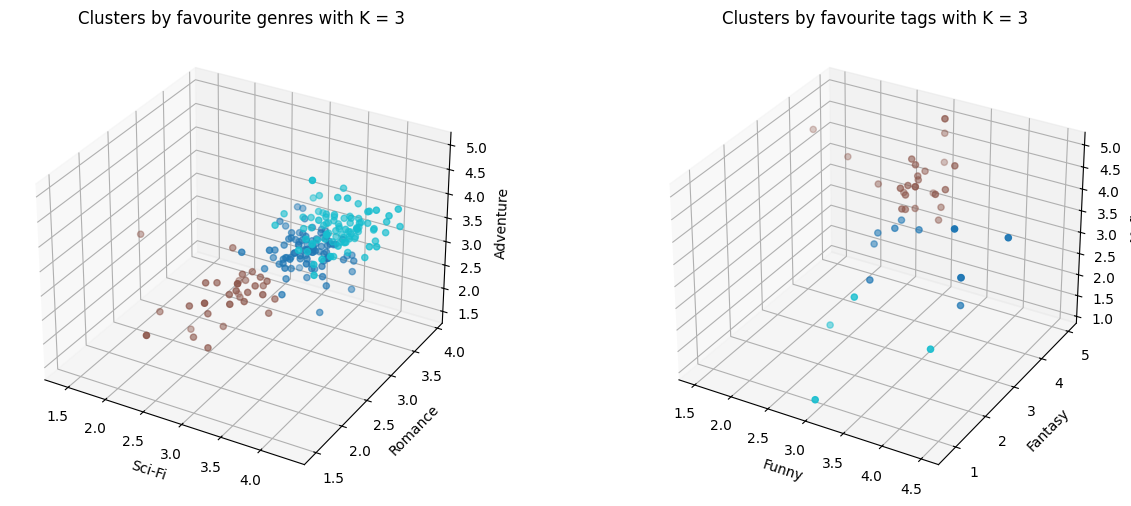

In [22]:
#Apply KMeans clustering by favourite genres and tags with K found before
genre_model_kmean = Cluster_data(movies_train, genre_k, KMeans)

tag_model_kmean = Cluster_data(tags_train, tag_K, KMeans)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_kmean,tag_model_kmean], genre_k, tag_K)


Birch Clustering Algorithm

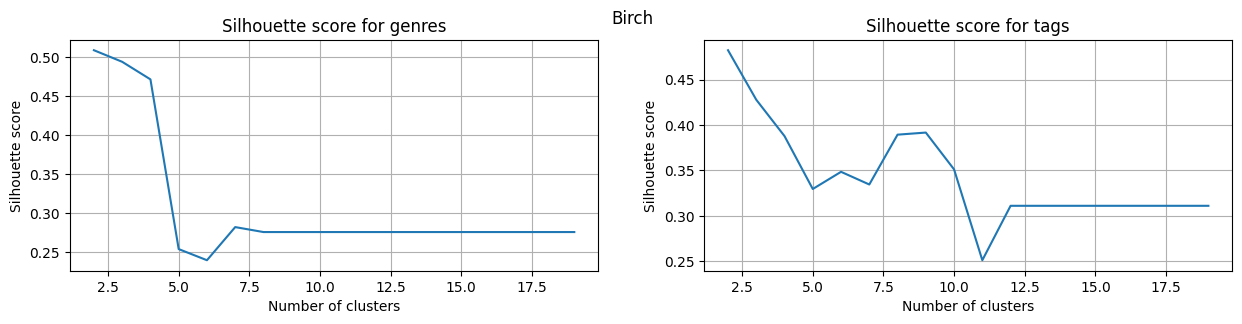

In [23]:
#optimization of K for Birch clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], Birch,'Birch')

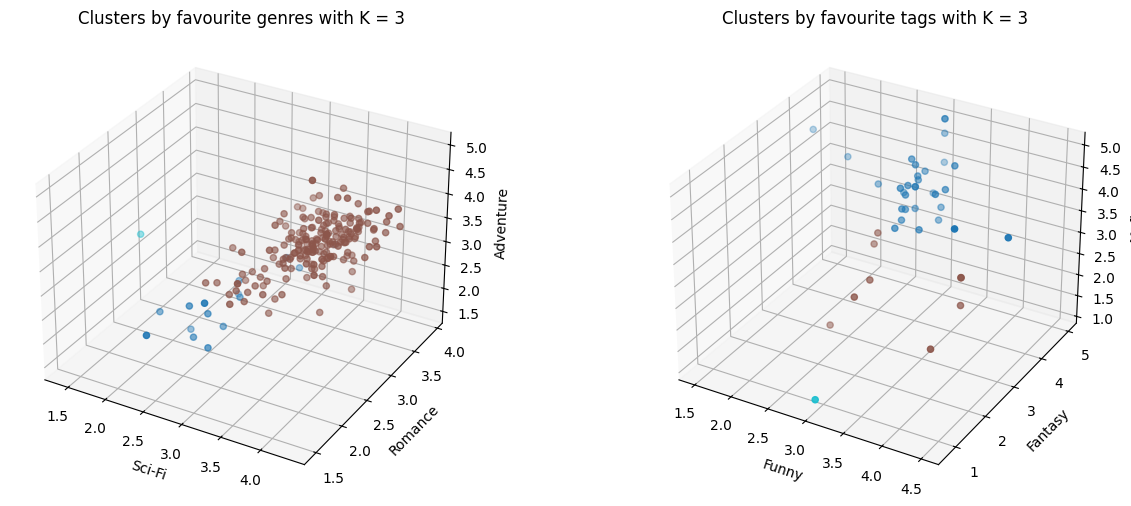

In [24]:
#implementation of Birch clustering by favourite genres
genre_model_birch = Cluster_data(movies_train, genre_k, Birch)

#implementation of Birch clustering by favourite tag
tag_model_birch = Cluster_data(tags_train, tag_K, Birch)


#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_birch,tag_model_birch],genre_k, tag_K)

Mini-Batch K-Means Clustering

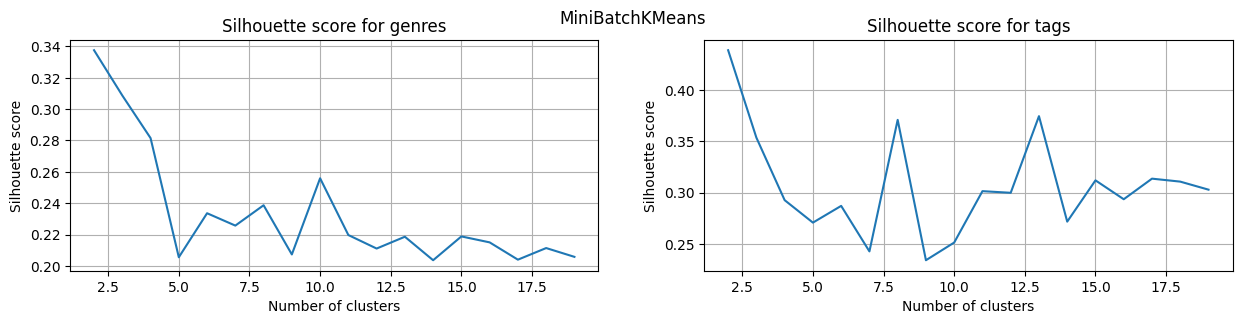

In [25]:
#optimization of K for Minibatch KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], MiniBatchKMeans,'MiniBatchKMeans')

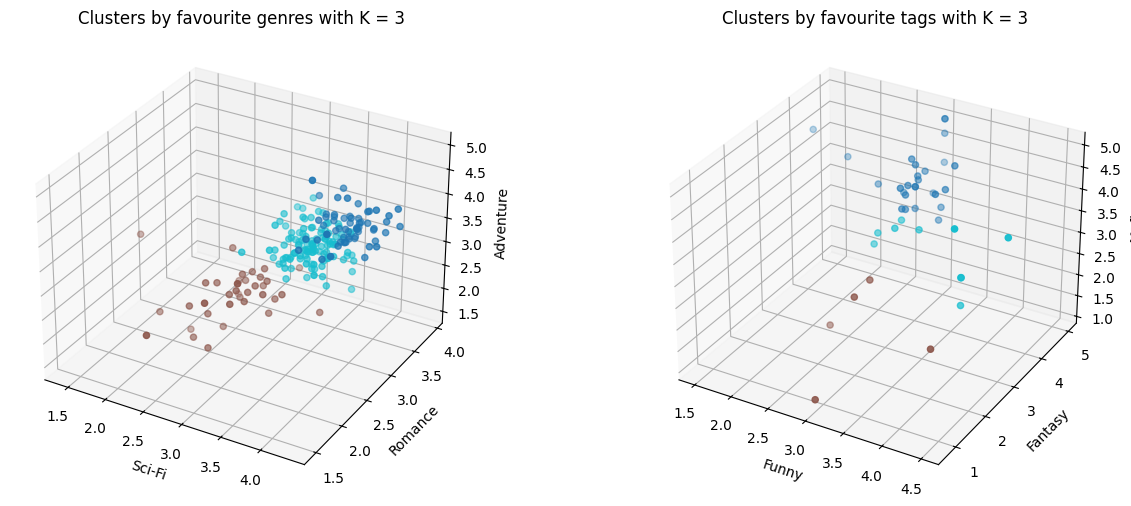

In [26]:
#implementation of MiniBatchKMeans clustering by favourite genres
genre_model_minibatcheskmeans = Cluster_data(movies_train, genre_k, MiniBatchKMeans)

#implementation of MiniBatchKMeans clustering by favourite tags
tag_model_minibatcheskmeans = Cluster_data(tags_train, tag_K, MiniBatchKMeans)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_minibatcheskmeans,tag_model_minibatcheskmeans],genre_k, tag_K)

Mean-Shift Clustering

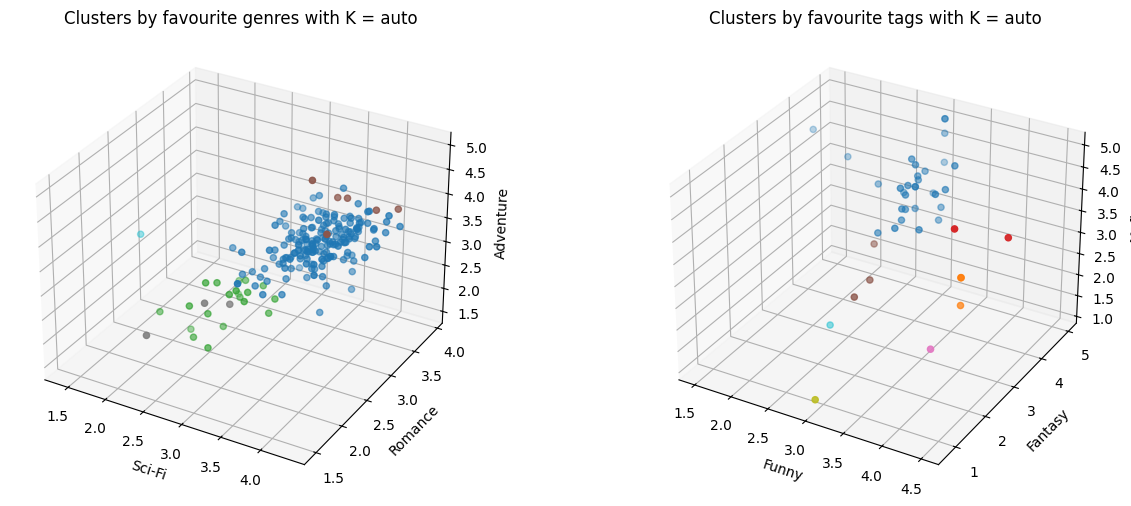

In [27]:
#implementation of MeanShift clustering by favourite genres
genre_model_meanshift = Cluster_data(movies_train, 3, MeanShift)

#implementation of MeanShift clustering by favourite tags
tag_model_meanshift = Cluster_data(tags_train, 3, MeanShift)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_meanshift,tag_model_meanshift], 'auto' , 'auto')

Affinity Propagation Clustering

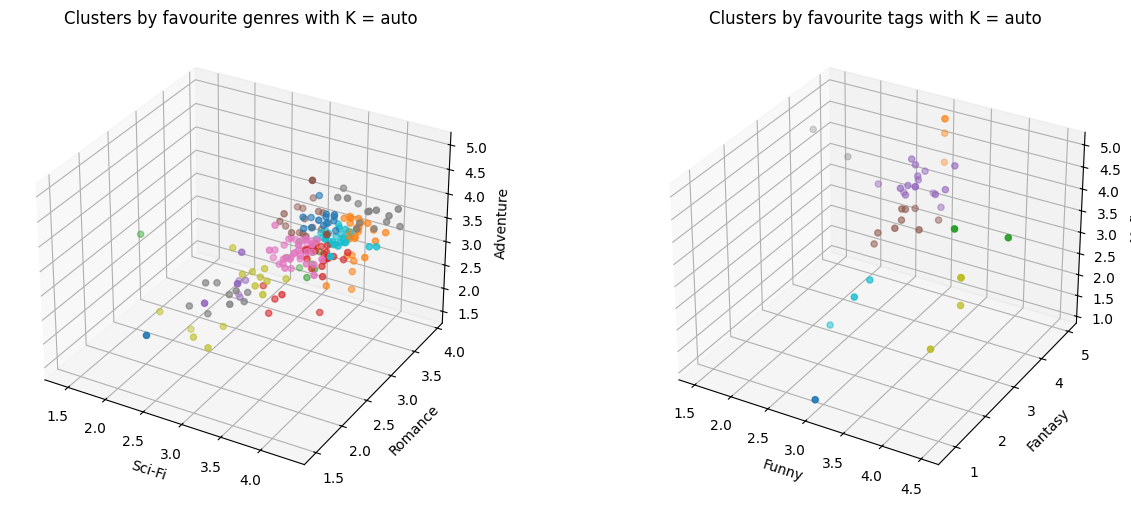

In [28]:
#implementation of AffinityPropagation clustering by favourite genres
genre_model_affinity = Cluster_data(movies_train, 3, AffinityPropagation)

#implementation of AffinityPropagation clustering by favourite tags
tag_model_affinity = Cluster_data(tags_train, 7, AffinityPropagation)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_affinity,tag_model_affinity], 'auto' , 'auto')

Agglomerative Clustering

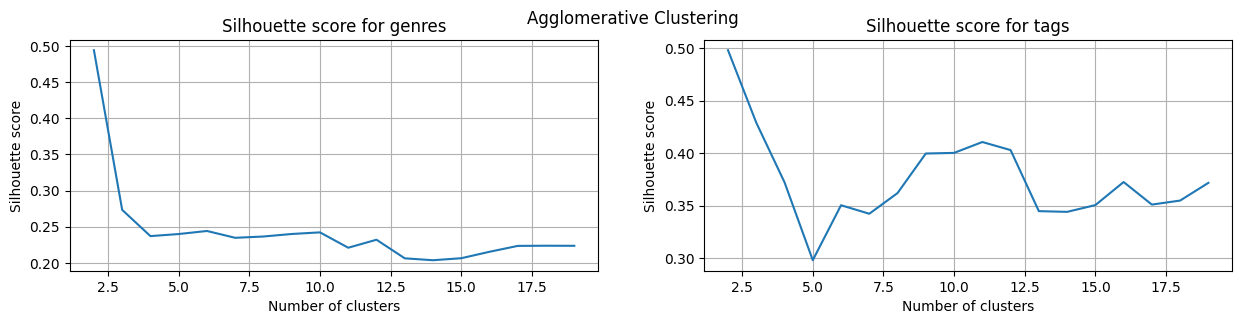

In [29]:
#optimization of K for Agglomerative KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([movies_train,tags_train], AgglomerativeClustering,'Agglomerative Clustering')

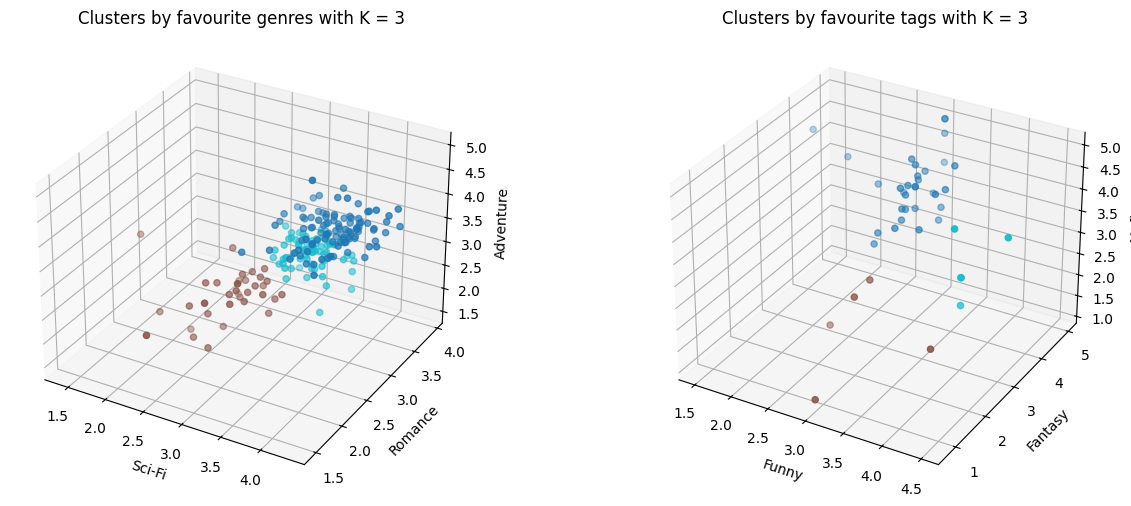

In [30]:
#implementation of AgglomerativeClustering clustering by favourite genres
genre_model_agglomerative = Cluster_data(movies_train, genre_k, AgglomerativeClustering)

#implementation of AgglomerativeClustering clustering by favourite tags
tag_model_agglomerative = Cluster_data(tags_train, tag_K, AgglomerativeClustering)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_agglomerative,tag_model_agglomerative], genre_k, tag_K)

Spectral Clustering

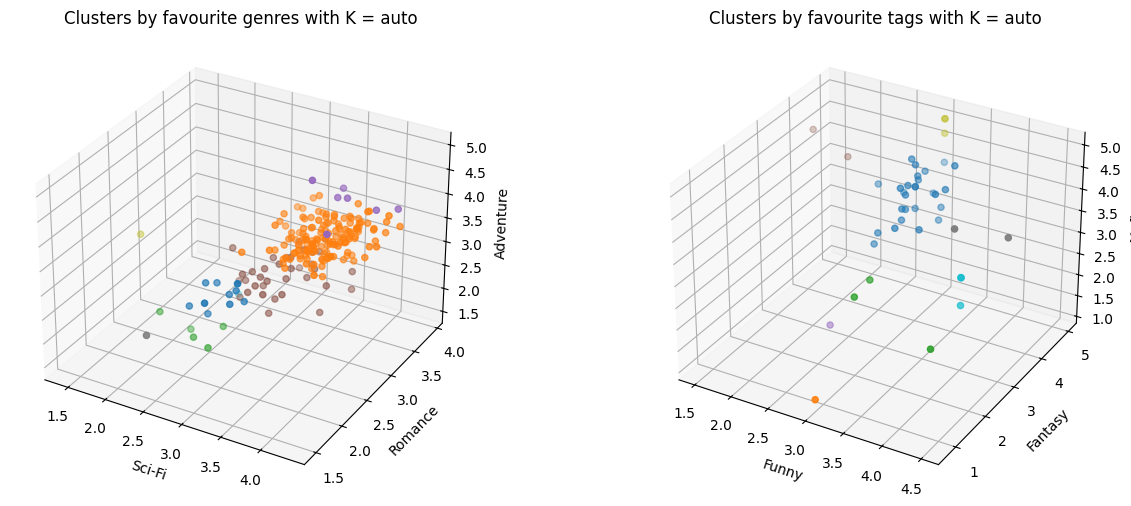

In [31]:
#implementation of SpectralClustering clustering by favourite genres
genre_model_spectral = Cluster_data(movies_train, 3, SpectralClustering)

#implementation of SpectralClustering clustering by favourite tags
tag_model_spectral  = Cluster_data(tags_train, 3, SpectralClustering)

#plot the clusters
plot_clusters_3d(movies_train, tags_train, [genre_model_spectral,tag_model_spectral], 'auto', 'auto')

Evaluation of performance for the 7 clustering models

In [32]:
# I used the mean of each cluster datapoints as centroids to have uniformity 
# between different models since some of them doesn't come with the centroids attribute 

def get_centroids(data, model):
    centroids = []
    predictions = model.labels_
    number_of_clusters = len(set(model.labels_))
    for i in range(number_of_clusters):
        cluster = data[predictions == i]
        cluster = cluster.drop('userId', axis=1)
        cluster = cluster.mean()
        centroids.append(cluster.values)            
    return centroids

In [33]:
# function to predic new data_points clusters for agglomerative 
# and spectral clustering which do not have a proper prediction method
def pseudo_predict_new_data(test_data, train_data, model):
    predictions = []
    for index, row in test_data.iterrows():
        min_distance = float('inf')
        cluster_id = -1
        for i in range(len(set(model.labels_))):
            distance = np.linalg.norm(row[1:] - get_centroids(train_data,model)[i])
            if distance < min_distance:
                min_distance = distance
                cluster_id = i
        predictions.append(model.labels_[cluster_id])
    return predictions

In [34]:
#Function to predict new data points from testset into existing models
def predict_new_data(test_data, model,train_data, model_name):
    X = test_data.copy()
    X = X.drop('userId', axis=1)
    if(model_name in['Agglomerative', 'Spectral']):
        predictions = pseudo_predict_new_data(test_data, train_data, model)
    else:
        predictions = model.predict(X)
    return predictions

In [35]:
def plot_results(model_names, genre_criteria, tag_criteria, max_index, title, y_label):

    color = (0.1, 0.2, 0.5, 0.3)
    highest_bar_color = 'green'
    fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(15,5))
    ax[0].bar(model_names, genre_criteria, color = color)
    #ax[0].set_xlabel('Clustering Models')
    ax[0].set_ylabel(y_label)
    ax[0].set_title(f'{title} genre')
    ax[0].set_xticklabels(model_names, rotation=45)
    bars = ax[0].get_children() 
    bars[max_index[0]].set_color(highest_bar_color)

    ax[1].bar(model_names, tag_criteria, color = color)
    #ax[1].set_xlabel('Clustering Models')
    ax[1].set_ylabel(y_label)
    ax[1].set_title(f'{title} tag')
    ax[1].set_xticklabels(model_names, rotation=45)
    bars = ax[1].get_children() 
    bars[max_index[1]].set_color(highest_bar_color)

    plt.show()

MEAN SQUARED ERROR

In [36]:
#function to calculate MSE for different clustering models
def calculate_MSE(test_data, model,train_data, model_name):
    new_predictions = predict_new_data(test_data, model,train_data, model_name)
    #new_predictions = model.labels_
    MSE = 0
    centroids = get_centroids(train_data, model)
    test_data = test_data.reset_index()
    for index, row in test_data.iterrows():
        user = row.drop('userId')
        user = user.drop('index')
        user = user.values
        cluster_id = new_predictions[index]
        MSE += np.square(np.linalg.norm((user - centroids[cluster_id])))
    return MSE/len(test_data)


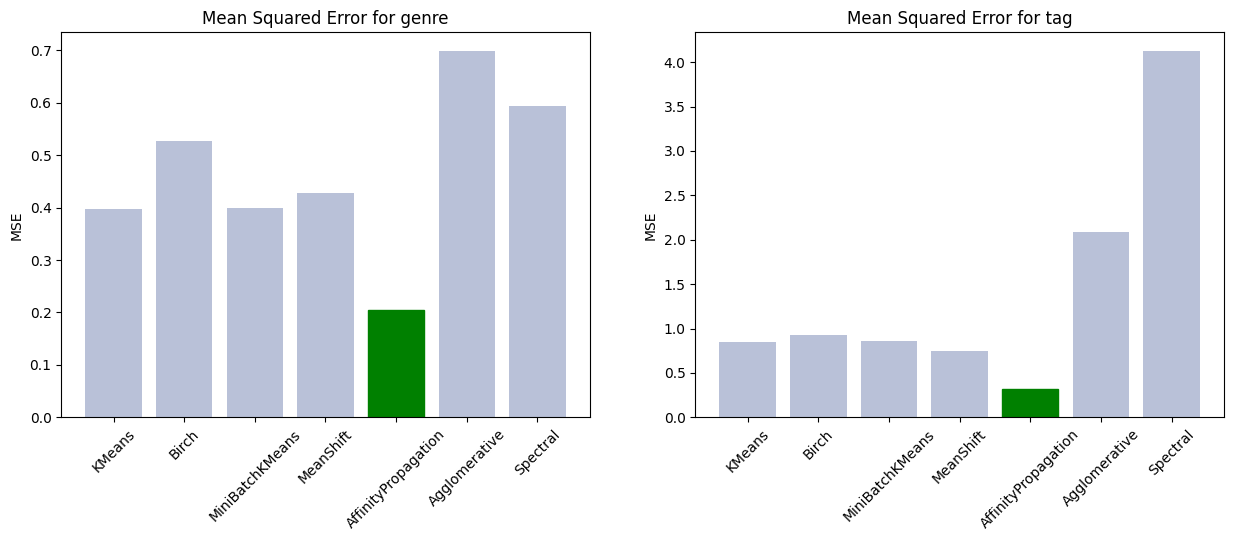

In [37]:
#plot the MSE for different clustering models
genre_models = [genre_model_kmean, genre_model_birch, genre_model_minibatcheskmeans, genre_model_meanshift, genre_model_affinity, genre_model_agglomerative, genre_model_spectral]
tag_models = [tag_model_kmean, tag_model_birch, tag_model_minibatcheskmeans, tag_model_meanshift, tag_model_affinity, tag_model_agglomerative, tag_model_spectral]
model_names = ['KMeans', 'Birch', 'MiniBatchKMeans', 'MeanShift', 'AffinityPropagation', 'Agglomerative', 'Spectral']

genre_MSE = []
for i in range(len(genre_models)):
    genre_MSE.append(calculate_MSE(movies_test, genre_models[i], movies_train, model_names[i]))
best_genre = genre_MSE.index(min(genre_MSE))

tag_MSE = []
for i in range(len(tag_models)):
    tag_MSE.append(calculate_MSE(tags_test, tag_models[i], tags_train, model_names[i]))
best_tag = tag_MSE.index(min(tag_MSE))


plot_results(model_names, genre_MSE, tag_MSE, [best_genre, best_tag], 'Mean Squared Error for', 'MSE')

DUNN'S INDEX

In [38]:
#a function to calculate the Dunn index for different existing clustering models
def calculate_Dunn_index(data, model):
    centroids = []
    predictions = model.labels_
    number_of_clusters = len(set(model.labels_))
    centroids = get_centroids(data, model)
    min_distance = float('inf')
    for i in range(number_of_clusters):
        for j in range(i+1, number_of_clusters):
            distance = np.linalg.norm(centroids[i] - centroids[j])
            if distance < min_distance:
                min_distance = distance
    max_distance = 0
    for i in range(number_of_clusters):
        for j in range(len(data)):
            if predictions[j] == i:
                distance = np.linalg.norm(data.iloc[j].drop('userId').values - centroids[i])
                if distance > max_distance:
                    max_distance = distance
    return min_distance/max_distance

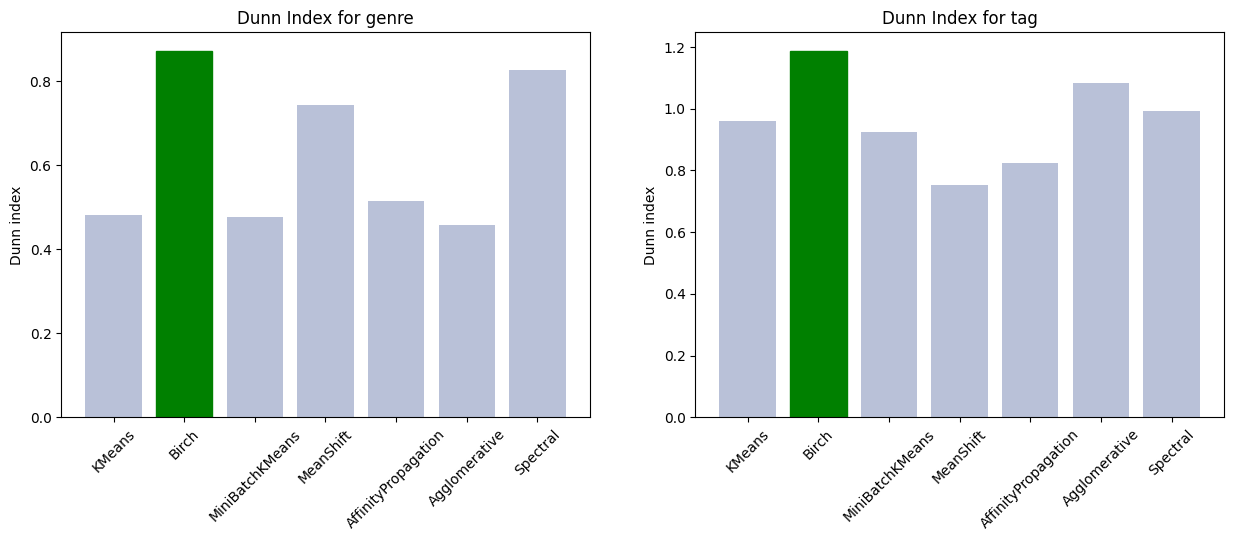

In [39]:
genre_Dunn = []
for i in range(len(genre_models)):
    genre_Dunn.append(calculate_Dunn_index(movies_train, genre_models[i]))
best_genre = genre_Dunn.index(max(genre_Dunn))

tag_Dunn = []
for i in range(len(tag_models)):
    tag_Dunn.append(calculate_Dunn_index(tags_train, tag_models[i]))
best_tag = tag_Dunn.index(max(tag_Dunn))

plot_results(model_names, genre_Dunn, tag_Dunn, [best_genre, best_tag], 'Dunn Index for', 'Dunn index')

AVARAGE SIMILARITY

In [40]:
def cosine_similarity(v1, v2):
  v1_norm = np.linalg.norm(v1)
  v2_norm = np.linalg.norm(v2)
  if v1_norm * v2_norm == 0:
    return 0
  return np.dot(v1, v2) / (v1_norm * v2_norm)


In [41]:
def average_similarity_between_clusters(data, cluster_labels, cluster1, cluster2):

  cluster1_data = data[cluster_labels == cluster1]
  cluster2_data = data[cluster_labels == cluster2]


  similarities = []
  for data1 in cluster1_data:
    for data2 in cluster2_data:
      similarities.append(cosine_similarity(data1, data2))

  if not similarities:
    return 0

  return np.mean(similarities)


In [42]:
 #compute the average similarity between clusters for every pair of clusters and then avarage them
def average_similarity(data, model):
  cluster_similarities = []
  labels = model.labels_
  for cluster1 in range(len(set(labels))):
    for cluster2 in range(cluster1+1, len(set(labels))):
      if cluster1 != cluster2:
        cluster_similarities.append(average_similarity_between_clusters(data, labels, cluster1, cluster2))
  return np.mean(cluster_similarities)

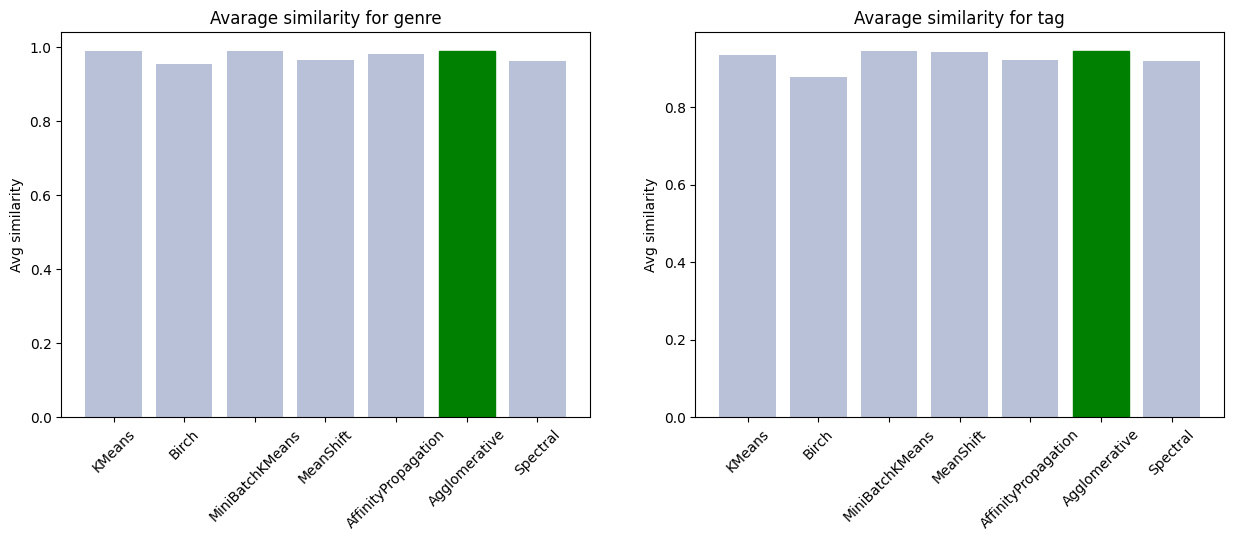

In [43]:
genre_similarities = []
for i in range(len(genre_models)):
    genre_similarities.append(average_similarity(movies_train.drop('userId', axis=1).values, genre_models[i]))
best_genre = genre_similarities.index(max(genre_similarities))

tag_similarities = []
for i in range(len(tag_models)):
    tag_similarities.append(average_similarity(tags_train.drop('userId', axis= 1).values, tag_models[i]))
best_tag = tag_similarities.index(max(tag_similarities))

plot_results(model_names, genre_similarities, tag_similarities, [best_genre, best_tag], 'Avarage similarity for', 'Avg similarity')

COMPUTATIONAL TIME

In [44]:
def evaluate_models(data, clustering_methods):
    results = []
    for method in clustering_methods:
        start = time.time()
        Cluster_data(data, 3, method)
        end = time.time()
        results.append((end-start)*1000)
    return results

genre_results = evaluate_models(movies_train, clustering_methods)
best_genre = genre_results.index(min(genre_results))
tag_results = evaluate_models(tags_train, clustering_methods)
best_tag = tag_results.index(min(tag_results))

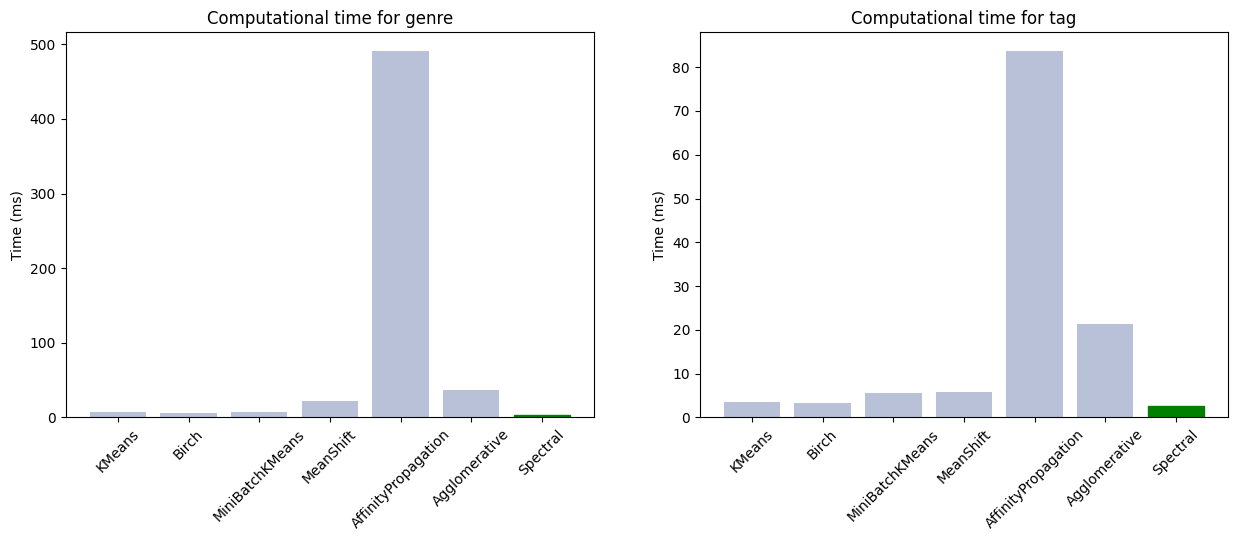

In [45]:
plot_results(model_names, genre_results, tag_results, [best_genre, best_tag], 'Computational time for', 'Time (ms)')

OTHER CRITERIA!!!!!!!!!!!!!!!!!!!!

scelgo numero di k per avere top_n_movies!!!!!!!
printo userId del test set da testare per le recommendations

In [46]:
#Function that returns the top N recommended movies for a given user 
def TOP_N_MOVIES_GENRE(model,user_id,N):
    if(user_id in movies_test['userId'].values):
        X = movies_test.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = predict_new_data(movies_test, model, movies_train)[new_user]
        cluster_ids = movies_train[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == movies_test.iloc[new_user]['userId']]
    elif(user_id in movies_train['userId'].values):
        X = movies_train.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = model.labels_[new_user]
        cluster_ids = movies_train[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == movies_train.iloc[new_user]['userId']]
    else:
        print('User not found')
        return
    cluster_movies_not_rated = ratings[ratings['userId'].isin(cluster_ids) & ~ratings['movieId'].isin(user_rated_movies['movieId'])].drop('userId', axis=1).groupby('movieId').mean().sort_values('rating', ascending=False).head(N)
    for(index, _) in cluster_movies_not_rated.iterrows():
        cluster_movies_not_rated.at[index, 'title'] = movies[movies['movieId'] == index]['title'].values[0]
    return cluster_movies_not_rated.drop('rating', axis=1)

TOP_N_MOVIES_GENRE(genre_model_birch, 609, 20)

,title
movieId,
91355,Asterix and the Vikings (Astérix et les Viking...
4334,Yi Yi (2000)
96935,My Left Eye Sees Ghosts (Ngo joh aan gin diy g...
7121,Adam's Rib (1949)
117192,Doctor Who: The Time of the Doctor (2013)
142444,The Editor (2015)
98279,"Fantastic Fear of Everything, A (2012)"
7096,Rivers and Tides (2001)
85295,Scooby-Doo! Curse of the Lake Monster (2010)


In [47]:
#do the same for tags clustering

def TOP_N_MOVIES_TAGS(model,user_id,N, model_name):
    if(user_id in tags_test['userId'].values):
        X = tags_test.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = predict_new_data(tags_test, model, tags_train, 'model_name')[new_user]
        cluster_ids = tags_train[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == tags_test.iloc[new_user]['userId']]
    elif(user_id in tags_train['userId'].values):
        X = tags_train.copy()
        X = X.reset_index()
        new_user = X[X['userId'] == user_id].index[0]
        cluster = model.labels_[new_user]
        cluster_ids = tags_train[model.labels_ == cluster]['userId']
        user_rated_movies = ratings[ratings['userId'] == tags_train.iloc[new_user]['userId']]
    else:
        print('User not found')
        return
    cluster_movies_not_rated = ratings[ratings['userId'].isin(cluster_ids) & ~ratings['movieId'].isin(user_rated_movies['movieId'])].drop('userId', axis=1).groupby('movieId').mean().sort_values('rating', ascending=False).head(N)
    for(index, _) in cluster_movies_not_rated.iterrows():
        cluster_movies_not_rated.at[index, 'title'] = movies[movies['movieId'] == index]['title'].values[0]
    return cluster_movies_not_rated.drop('rating', axis=1)

TOP_N_MOVIES_TAGS(tag_model_birch, 5, 20, 'birch')

,title
movieId,
4327,"Magnificent Seven, The (1960)"
4225,"Dish, The (2001)"
1957,Chariots of Fire (1981)
66934,Dr. Horrible's Sing-Along Blog (2008)
8638,Before Sunset (2004)
4535,"Man from Snowy River, The (1982)"
4454,More (1998)
4356,Gentlemen Prefer Blondes (1953)
68954,Up (2009)


Now I will perform clustering of the dataset exploiting all the available dimensions by considering all 20 genres in my analysis

Parallel to that, I will consider just the 20 most popular tags to avoid the "Curse of Dimensionality" that would certainly affect the study by considering all the 1589 different tags.

In [77]:
#find 20 most popular tags
tag_counts = tags['tag'].value_counts()
tag_counts = tag_counts.head(20)
tag_counts

tag
In Netflix queue      131
atmospheric            36
thought-provoking      24
superhero              24
funny                  23
surreal                23
Disney                 23
religion               22
sci-fi                 21
quirky                 21
dark comedy            21
psychology             21
suspense               20
twist ending           19
visually appealing     19
crime                  19
politics               18
mental illness         16
music                  16
time travel            16
Name: count, dtype: int64

In [83]:
#get a list of all genres
all_genres = []
for genre in movies['genres']:
    all_genres.extend(genre.split('|'))
all_genres = list(set(all_genres))

column_names_genre = all_genres.copy()
column_names_genre.insert(0, 'userId')

In [100]:
#get a list of 20 most popular tags
all_tags = list(tag_counts.index)

column__names_tags = all_tags.copy()
column__names_tags.insert(0, 'userId')

In [101]:
all_genre_ratings = get_genre_ratings(ratings, movies, all_genres, column_names )
all_genre_ratings.head()

,userId,IMAX,Comedy,War,Children,Mystery,Fantasy,Western,Adventure,(no genres listed),...,Musical,Sci-Fi,Drama,Romance,Action,Film-Noir,Crime,Thriller,Animation,Horror
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,NaN,4.28,4.50,4.55,4.17,4.30,4.29,4.39,NaN,...,4.68,4.22,4.53,4.31,4.32,5.0,4.36,4.15,4.69,3.47
2,3.0,3.75,4.00,4.50,NaN,4.00,NaN,3.50,4.17,NaN,...,NaN,3.88,3.88,4.50,3.95,NaN,3.80,3.70,NaN,3.00
3,4.0,NaN,1.00,0.50,0.50,5.00,3.38,NaN,2.73,NaN,...,0.50,4.20,0.75,0.50,3.57,NaN,0.50,4.14,0.50,4.69
4,5.0,3.00,3.51,3.57,3.80,3.48,3.68,3.80,3.66,NaN,...,4.00,2.83,3.48,3.38,3.32,4.0,3.81,3.55,4.00,4.25


In [102]:
# compute the avarage rating of each user
user_means = all_genre_ratings.mean(axis=1)

#for every row, fill the empty values with the mean of that row
for row in range(len(all_genre_ratings)):
    for column in range(1, len(all_genre_ratings.columns)):
        if pd.isnull(all_genre_ratings.iloc[row, column]):
            all_genre_ratings.iloc[row, column] = user_means[row]

In [103]:
all_tags_ratings = get_tag_ratings(ratings, tags, all_tags, column__names_tags)
all_tags_ratings.head()

,userId,In Netflix queue,atmospheric,thought-provoking,superhero,funny,surreal,Disney,religion,sci-fi,...,dark comedy,psychology,suspense,twist ending,visually appealing,crime,politics,mental illness,music,time travel
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,4.0,3.67,4.50,4.2,4.00,5.0,4.62,5.0,4.75,...,4.6,3.00,3.29,4.67,NaN,4.5,5.0,5.0,4.0,4.33
2,3.0,NaN,4.00,3.67,4.0,3.83,4.0,NaN,NaN,3.50,...,3.0,4.25,4.00,4.00,4.0,4.5,5.0,NaN,4.0,NaN
3,4.0,NaN,NaN,0.50,NaN,NaN,NaN,0.50,NaN,NaN,...,NaN,0.50,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN
4,5.0,4.5,2.00,2.67,NaN,2.50,2.0,4.20,4.5,3.67,...,3.0,3.40,3.50,2.57,3.0,2.8,4.0,2.0,3.5,2.00


In [104]:
# compute the avarage rating of each user
user_means = all_tags_ratings.mean(axis=1)

#for every row, fill the empty values with the mean of that row
for row in range(len(all_tags_ratings)):
    for column in range(1, len(all_tags_ratings.columns)):
        if pd.isnull(all_tags_ratings.iloc[row, column]):
            all_tags_ratings.iloc[row, column] = user_means[row]

Training and test set separation

In [95]:
#divide the data into training and test set by 80% and 20% respectively
all_genre_ratings_train = all_genre_ratings.sample(frac=0.8, random_state=0)
all_genre_ratings_test = all_genre_ratings.drop(all_genre_ratings_train.index)

all_tags_ratings_train = all_tags_ratings.sample(frac=0.8, random_state=0)
all_tags_ratings_test = all_tags_ratings.drop(all_tags_ratings_train.index)

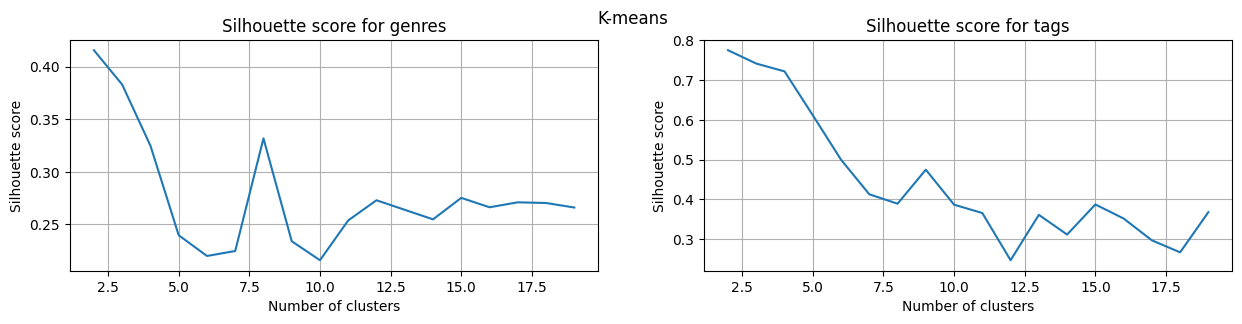

In [105]:
#optimization of K for KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([all_genre_ratings_train,all_tags_ratings_train], KMeans,'K-means')

In [106]:
#Apply KMeans clustering by favourite genres and tags with K found before
genre_model_kmean = Cluster_data(all_genre_ratings_train, genre_k, KMeans)

tag_model_kmean = Cluster_data(all_tags_ratings_train, tag_K, KMeans)

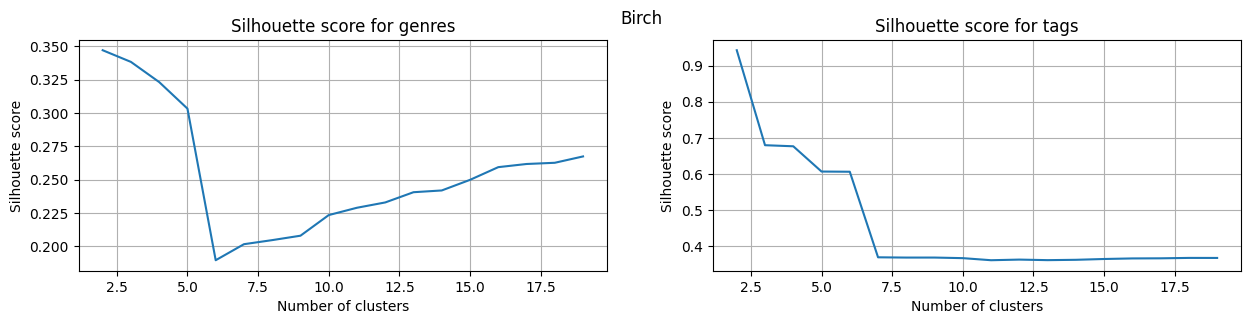

In [107]:
#Optimization of K for Birch clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([all_genre_ratings_train,all_tags_ratings_train], Birch,'Birch')

In [109]:
#implementation of Birch clustering by favourite genres
genre_model_birch = Cluster_data(all_genre_ratings_train, genre_k, Birch)

#implementation of Birch clustering by favourite tag
tag_model_birch = Cluster_data(all_tags_ratings_train, tag_K, Birch)

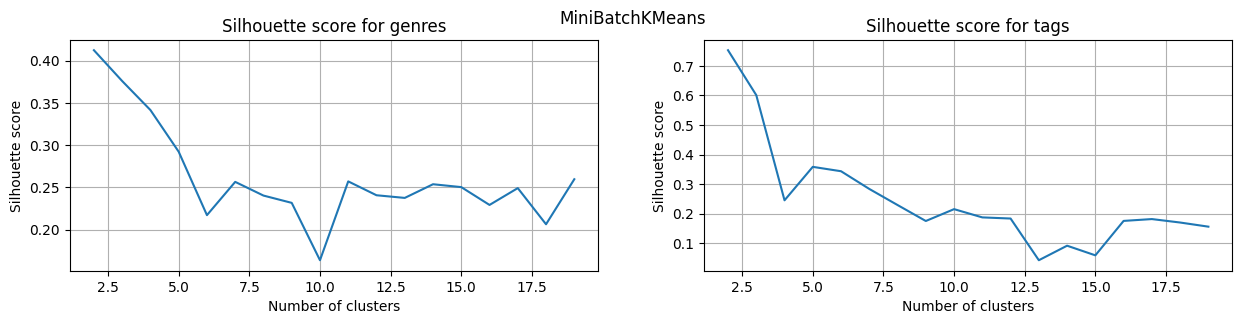

In [111]:
#Optimization of K for MiniBatchKMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([all_genre_ratings_train,all_tags_ratings_train], MiniBatchKMeans,'MiniBatchKMeans')

In [112]:
#implementation of MiniBatchKMeans clustering by favourite genres
genre_model_minibatcheskmeans = Cluster_data(all_genre_ratings_train, genre_k, MiniBatchKMeans)

#implementation of MiniBatchKMeans clustering by favourite tags
tag_model_minibatcheskmeans = Cluster_data(all_tags_ratings_train, tag_K, MiniBatchKMeans)

In [113]:
#implementation of MeanShift clustering by favourite genres
genre_model_meanshift = Cluster_data(all_genre_ratings_train, 3, MeanShift)

#implementation of MeanShift clustering by favourite tags
tag_model_meanshift = Cluster_data(all_tags_ratings_train, 3, MeanShift)

In [114]:
#implementation of AffinityPropagation clustering by favourite genres
genre_model_affinity = Cluster_data(all_genre_ratings_train, 3, AffinityPropagation)

#implementation of AffinityPropagation clustering by favourite tags
tag_model_affinity = Cluster_data(all_tags_ratings_train, 7, AffinityPropagation)

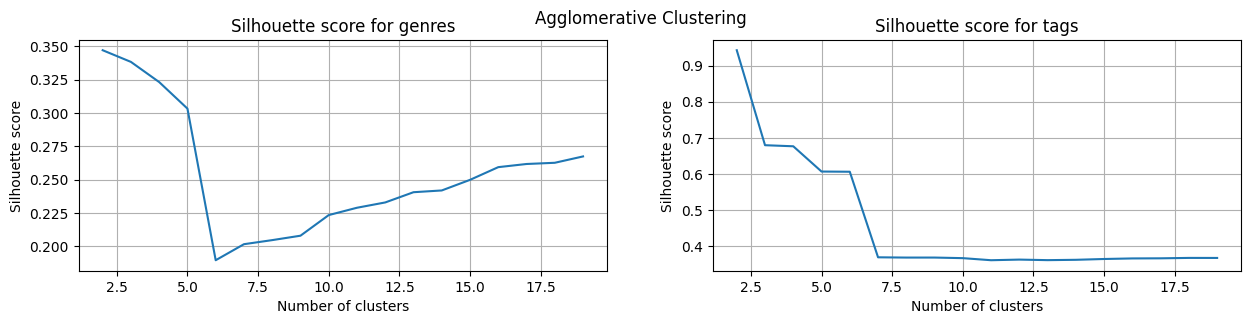

In [115]:
#optimization of K for Agglomerative KMeans clustering by silhouette score
genre_k, tag_K = silhouette_score_plot([all_genre_ratings_train,all_tags_ratings_train], AgglomerativeClustering,'Agglomerative Clustering')

In [116]:
#implementation of AgglomerativeClustering clustering by favourite genres
genre_model_agglomerative = Cluster_data(all_genre_ratings_train, genre_k, AgglomerativeClustering)

#implementation of AgglomerativeClustering clustering by favourite tags
tag_model_agglomerative = Cluster_data(all_tags_ratings_train, tag_K, AgglomerativeClustering)

In [117]:
#implementation of SpectralClustering clustering by favourite genres
genre_model_spectral = Cluster_data(all_genre_ratings_train, 3, SpectralClustering)

#implementation of SpectralClustering clustering by favourite tags
tag_model_spectral  = Cluster_data(all_tags_ratings_train, 3, SpectralClustering)

IMPLEMENT MODEL EVALUATION !!!!!!!!!!!!!

In [55]:
#TODO implement the other evaluation metrics (indexes, try others)
#try 3 different methods:  1)DONE  2)EVALUATE THEM  3)Dmensionality reduction ----> then compare them
#clean code/move functions to a different file
#add comments
#presentation!